In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/INDF.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,7400.0,7500.0,7375.0,7500.0,5944.014160,9181300
1,2017-12-19,7500.0,7700.0,7475.0,7650.0,6062.894531,15706100
2,2017-12-20,7650.0,7700.0,7425.0,7550.0,5983.640625,14606300
3,2017-12-21,7525.0,7600.0,7475.0,7600.0,6023.267578,10857700
4,2017-12-22,7600.0,7625.0,7575.0,7625.0,6043.080566,4686000


In [3]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [4]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0
...,...,...,...,...,...
1489,2023-12-08,6400.0,6400.0,6425.0,6325.0
1490,2023-12-11,6375.0,6400.0,6400.0,6325.0
1491,2023-12-12,6425.0,6375.0,6425.0,6350.0
1492,2023-12-13,6400.0,6400.0,6425.0,6350.0


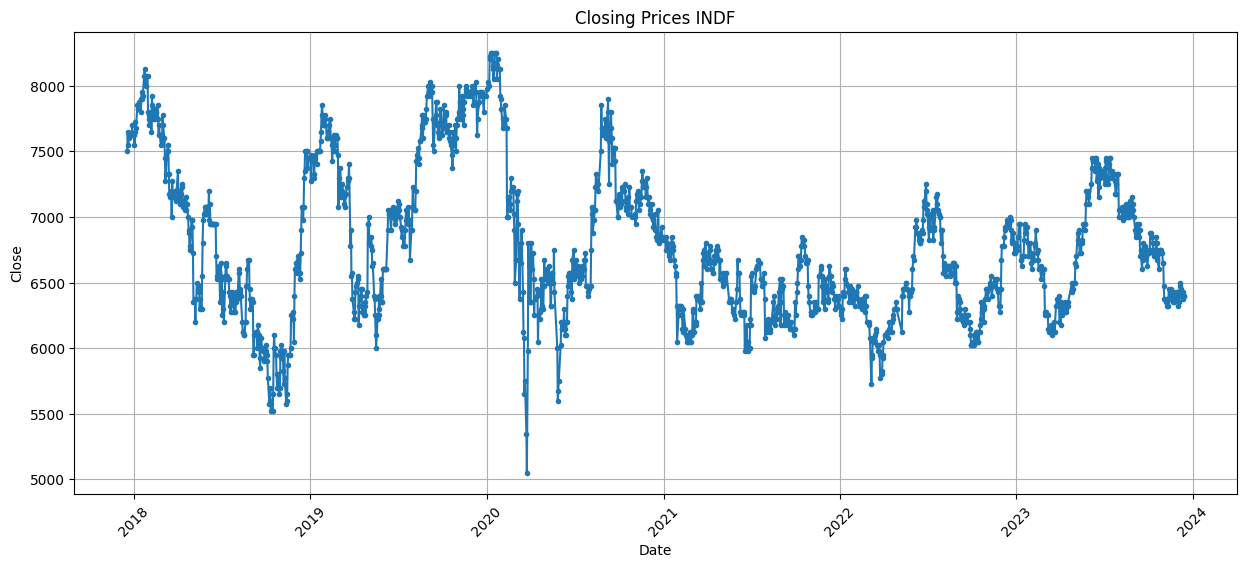

In [5]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

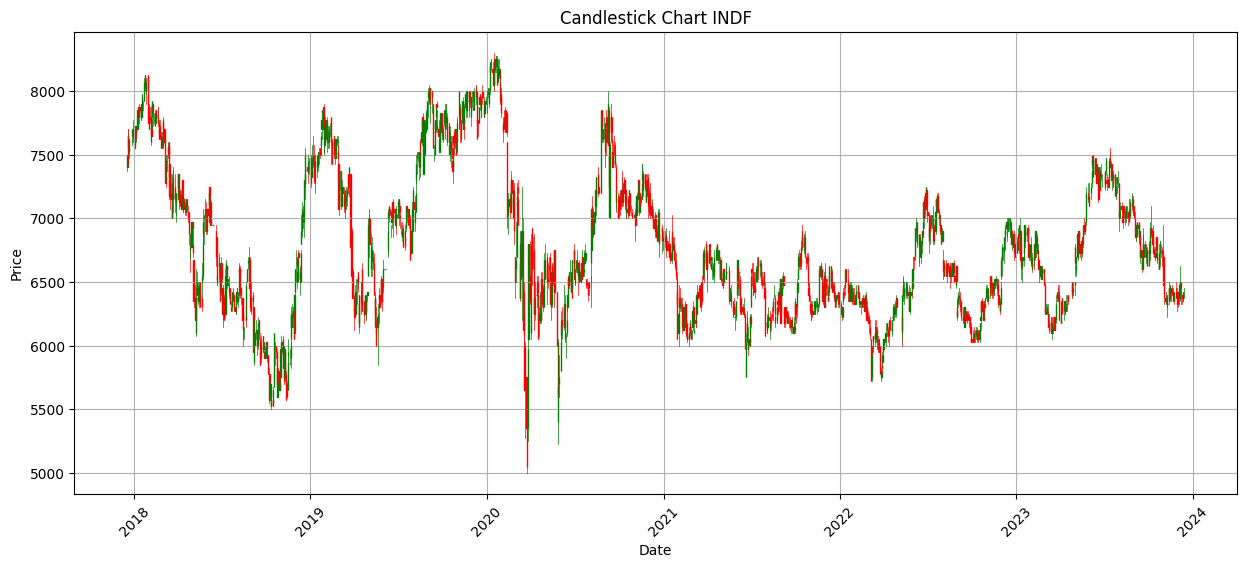

In [6]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart INDF')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

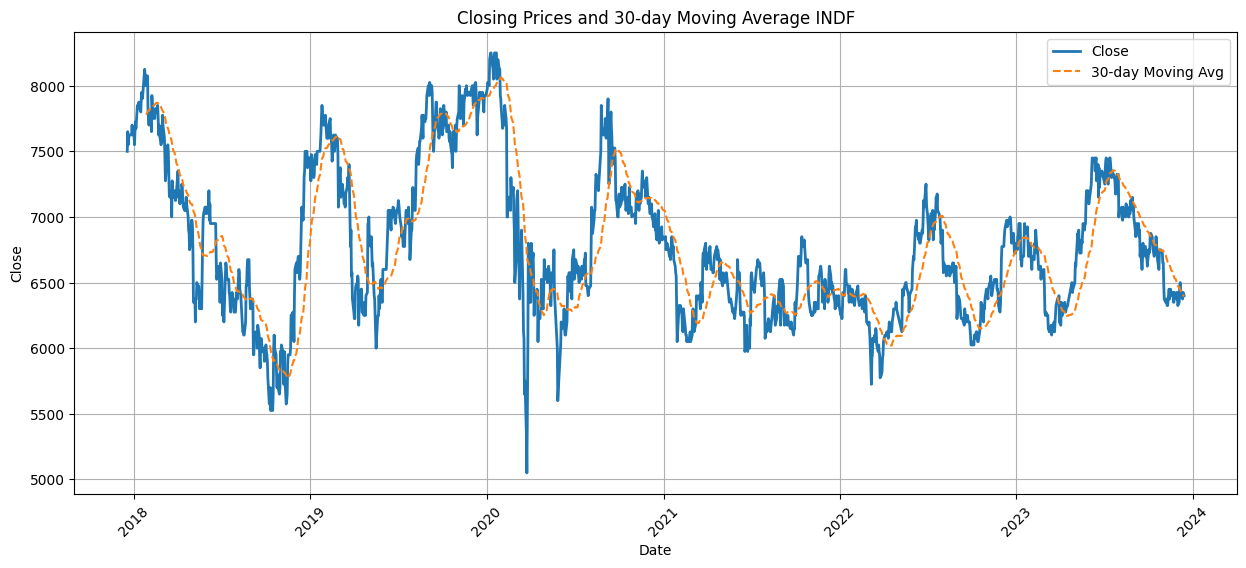

In [7]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average INDF')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,7500.0,7400.0,7500.0,7375.0
1,2017-12-19,7650.0,7500.0,7700.0,7475.0
2,2017-12-20,7550.0,7650.0,7700.0,7425.0
3,2017-12-21,7600.0,7525.0,7600.0,7475.0
4,2017-12-22,7625.0,7600.0,7625.0,7575.0


In [9]:
new_df = specific_df.reset_index()['Close']

In [10]:
new_df

0       7500.0
1       7650.0
2       7550.0
3       7600.0
4       7625.0
         ...  
1489    6400.0
1490    6375.0
1491    6425.0
1492    6400.0
1493    6400.0
Name: Close, Length: 1494, dtype: float64

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

Partisi Data

In [12]:
train_size = int(len(scaled_data)*0.8) #80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1135, 60)
(1135,)


Testing set size:-
(239, 60)
(239,)


(None, None)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

LAyer = 3

dropout = 0.6

In [16]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.6))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.6))

model.add(LSTM(units=50))
model.add(Dropout(0.6))

model.add(Dense(units=1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [18]:
model.compile(loss='mean_squared_error',optimizer='adam')

epoch = 150

batchsize = 8

In [19]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=150,
          batch_size=8,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/150

142/142 [==============================] - 28s 75ms/step - loss: 0.0365 - val_loss: 0.0037
Epoch 2/150
142/142 [==============================] - 8s 57ms/step - loss: 0.0206 - val_loss: 0.0042
Epoch 3/150
142/142 [==============================] - 8s 60ms/step - loss: 0.0187 - val_loss: 0.0029
Epoch 4/150
142/142 [==============================] - 180s 1s/step - loss: 0.0165 - val_loss: 0.0029
Epoch 5/150
142/142 [==============================] - 176s 1s/step - loss: 0.0136 - val_loss: 0.0021
Epoch 6/150
142/142 [==============================] - 8s 54ms/step - loss: 0.0134 - val_loss: 0.0020
Epoch 7/150
142/142 [==============================] - 13s 93ms/step - loss: 0.0111 - val_loss: 0.0024
Epoch 8/150
142/142 [==============================] - 8s 58ms/step - loss: 0.0100 - val_loss: 0.0018
Epoch 9/150
142/142 [==============================] - 9s 62ms/step - loss: 0.0102 - val_loss: 0.0023
Epoch 10/150
142/142 [==============================] - 9s 66ms/step - loss: 0.

In [20]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 1s 65ms/step


In [21]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [22]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04196691569234394
0.026216907668405044


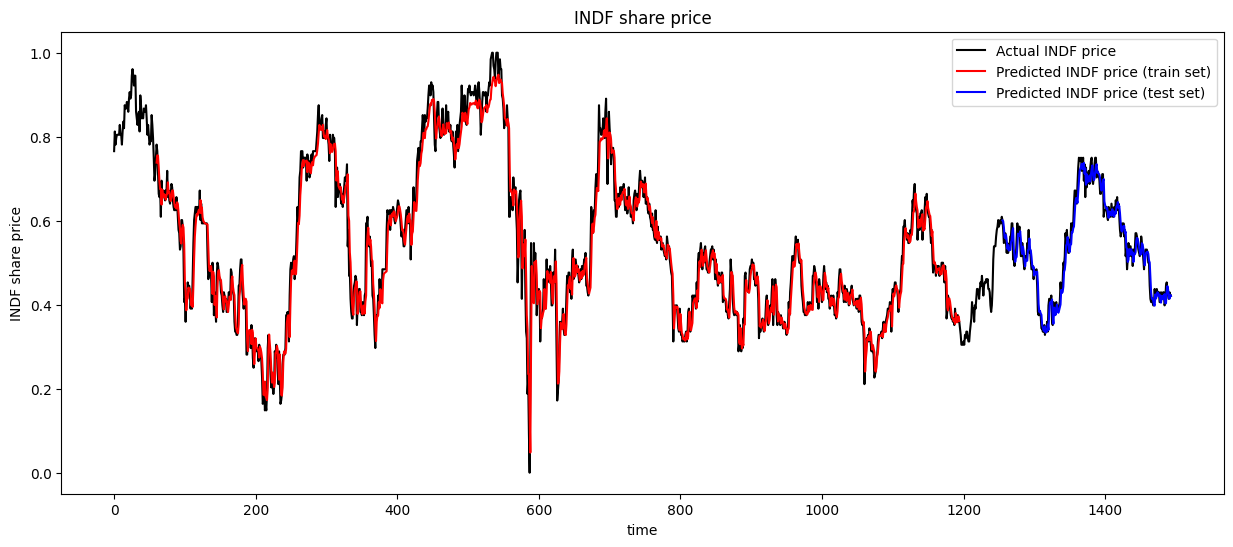

In [23]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [24]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 94ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6396.32666015625
Day 2: Predicted Price = 6388.923828125
Day 3: Predicted Price = 6381.88720703125
Day 4: Predicted Price = 6375.15966796875
Day 5: Predicted Price = 6368.59375
Day 6: Predicted Price = 6362.09716796875
Day 7: Predicted Price = 6355.6396484375
Day 8: Predicted Price = 6349.21728515625
Day 9: Predicted Price = 6342.8369140625
Day 10: Predicted Price = 6336.5068359375
Day 11: Predicted Price = 6330.23583984375
Day 12: Predicted Price = 6324.03125
Day 13: Predicted Price = 6317.89990234375
Day 14: Predicted Price = 6311.8466796875
Day 15: Predicted Price = 6305.876953125
Day 16: Predicted Price = 6299.994140625
Day 17: Predicted Price = 6294.201171875
Day 18: Predicted Price = 6288.501953125
Day 19: Predicted Price = 6282.8974609375
Day 20: Predicted Price = 6277.39111328125
Day 21: Predicted Price = 6271.98388671875
Day 22: Predicted Price = 6266.677734375
Day 23

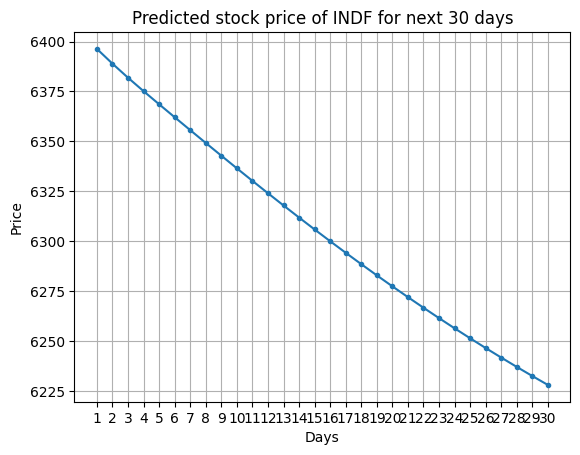

In [25]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [26]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 43ms/step - loss: 6.8733e-04
Validation Loss: 0.000687326246406883
Validation MSE Loss: 0.000687326246406883


In [27]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04196691569234394
Testing RMSE: 0.026216907668405044


batchsize = 16

In [28]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=150,
          batch_size=16,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/150


71/71 [==============================] - 10s 143ms/step - loss: 0.0035 - val_loss: 7.2419e-04
Epoch 2/150
71/71 [==============================] - 3s 45ms/step - loss: 0.0036 - val_loss: 8.0793e-04
Epoch 3/150
71/71 [==============================] - 4s 51ms/step - loss: 0.0033 - val_loss: 7.8066e-04
Epoch 4/150
71/71 [==============================] - 3s 48ms/step - loss: 0.0034 - val_loss: 8.4254e-04
Epoch 5/150
71/71 [==============================] - 3s 40ms/step - loss: 0.0032 - val_loss: 7.1572e-04
Epoch 6/150
71/71 [==============================] - 3s 45ms/step - loss: 0.0037 - val_loss: 8.1233e-04
Epoch 7/150
71/71 [==============================] - 4s 54ms/step - loss: 0.0034 - val_loss: 6.9005e-04
Epoch 8/150
71/71 [==============================] - 4s 56ms/step - loss: 0.0035 - val_loss: 7.5615e-04
Epoch 9/150
71/71 [==============================] - 4s 50ms/step - loss: 0.0035 - val_loss: 7.1021e-04
Epoch 10/150
71/71 [==============================] - 3s 43ms/step - loss:

In [29]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 45ms/step


In [30]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [31]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04126435957942209
0.026058462684207747


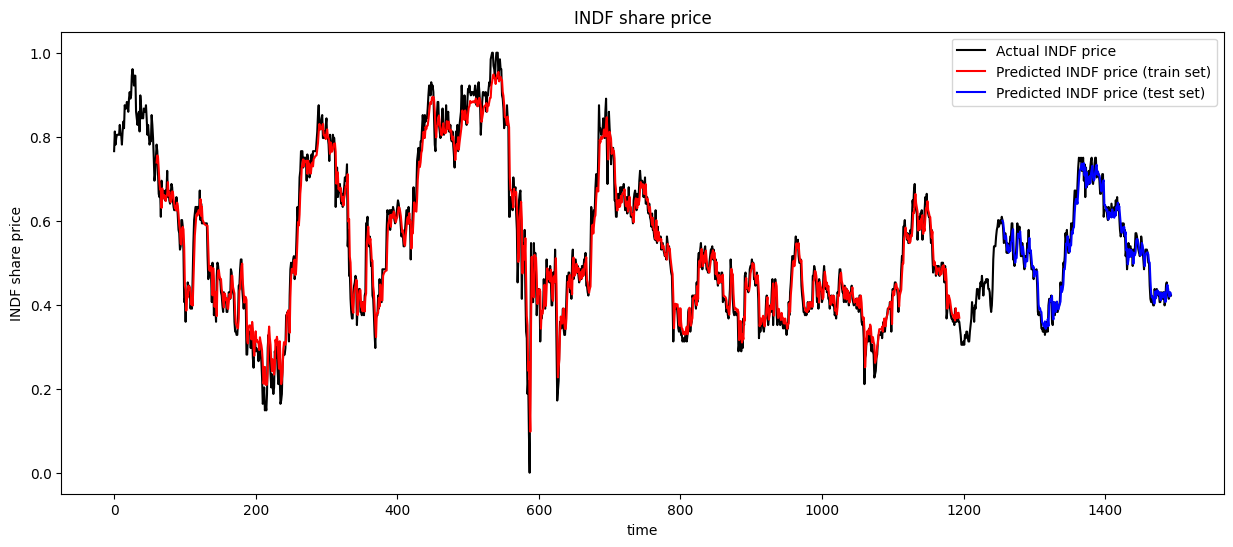

In [32]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [33]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 94ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6407.24267578125
Day 2: Predicted Price = 6411.091796875
Day 3: Predicted Price = 6414.0
Day 4: Predicted Price = 6416.4130859375
Day 5: Predicted Price = 6418.49609375
Day 6: Predicted Price = 6420.3671875
Day 7: Predicted Price = 6422.0869140625
Day 8: Predicted Price = 6423.6884765625
Day 9: Predicted Price = 6425.1962890625
Day 10: Predicted Price = 6426.6279296875
Day 11: Predicted Price = 6427.99365234375
Day 12: Predicted Price = 6429.296875
Day 13: Predicted Price = 6430.5390625
Day 14: Predicted Price = 6431.71826171875
Day 15: Predicted Price = 6432.83447265625
Day 16: Predicted Price = 6433.88671875
Day 17: Predicted Price = 6434.87548828125
Day 18: Predicted Price = 6435.8017578125
Day 19: Predicted Price = 6436.669921875
Day 20: Predicted Price = 6437.48095703125
Day 21: Predicted Price = 6438.23828125
Day 22: Predicted Price = 6438.9462890625
Day 23: Predicted Pr

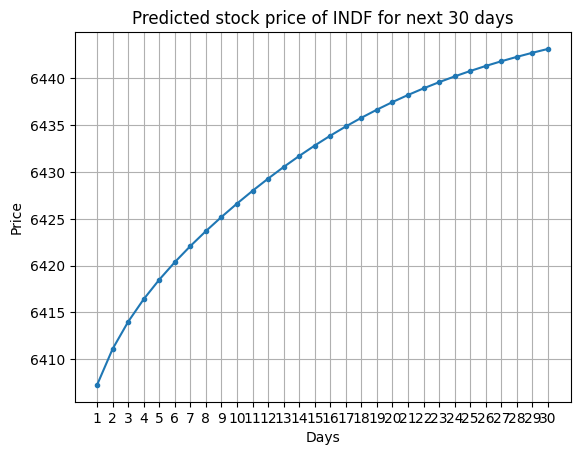

In [34]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [35]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 5s 426ms/step - loss: 6.7904e-04
Validation Loss: 0.0006790434708818793
Validation MSE Loss: 0.0006790434708818793


In [36]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04126435957942209
Testing RMSE: 0.026058462684207747


batchsize = 32

In [37]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=150,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/150


36/36 [==============================] - 16s 443ms/step - loss: 0.0033 - val_loss: 8.5932e-04
Epoch 2/150
36/36 [==============================] - 2s 51ms/step - loss: 0.0034 - val_loss: 6.9577e-04
Epoch 3/150
36/36 [==============================] - 2s 50ms/step - loss: 0.0032 - val_loss: 6.9255e-04
Epoch 4/150
36/36 [==============================] - 2s 62ms/step - loss: 0.0031 - val_loss: 6.8164e-04
Epoch 5/150
36/36 [==============================] - 3s 70ms/step - loss: 0.0034 - val_loss: 7.3204e-04
Epoch 6/150
36/36 [==============================] - 2s 61ms/step - loss: 0.0035 - val_loss: 6.8274e-04
Epoch 7/150
36/36 [==============================] - 2s 50ms/step - loss: 0.0028 - val_loss: 6.8309e-04
Epoch 8/150
36/36 [==============================] - 2s 67ms/step - loss: 0.0033 - val_loss: 7.3328e-04
Epoch 9/150
36/36 [==============================] - 2s 66ms/step - loss: 0.0032 - val_loss: 7.1160e-04
Epoch 10/150
36/36 [==============================] - 2s 56ms/step - loss:

In [38]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 11ms/step


In [39]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [40]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04061091543280094
0.025905248860703466


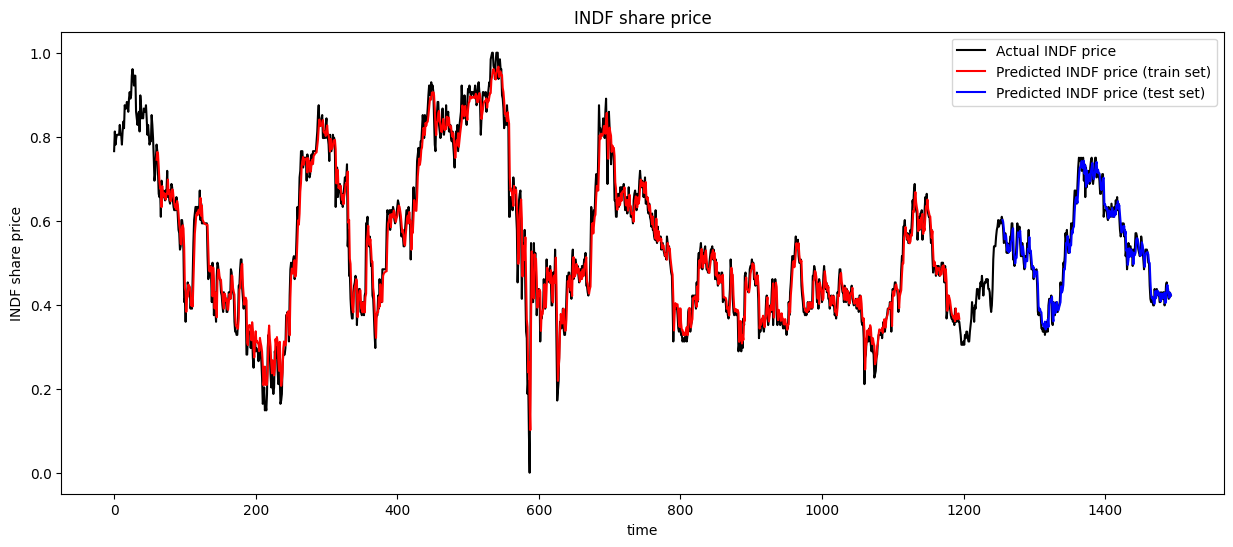

In [41]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [42]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 24ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6401.603515625
Day 2: Predicted Price = 6401.10302734375
Day 3: Predicted Price = 6400.67919921875
Day 4: Predicted Price = 6400.19921875
Day 5: Predicted Price = 6399.61181640625
Day 6: Predicted Price = 6398.9423828125
Day 7: Predicted Price = 6398.22412109375
Day 8: Predicted Price = 6397.48583984375
Day 9: Predicted Price = 6396.75244140625
Day 10: Predicted Price = 6396.04541015625
Day 11: Predicted Price = 6395.376953125
Day 12: Predicted Price = 6394.75439453125
Day 13: Predicted Price = 6394.1787109375
Day 14: Predicted Price = 6393.6484375
Day 15: Predicted Price = 6393.15966796875
Day 16: Predicted Price = 6392.70703125
Day 17: Predicted Price = 6392.28662109375
Day 18: Predicted Price = 6391.89599609375
Day 19: Predicted Price = 6391.53076171875
Day 20: Predicted Price = 6391.18994140625
Day 21: Predicted Price = 6390.87060546875
Day 22: Predicted Price = 6390.57226

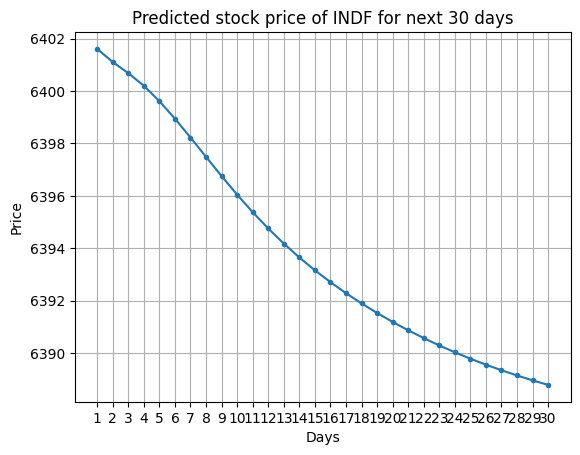

In [43]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [44]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 14ms/step - loss: 6.7108e-04
Validation Loss: 0.0006710818852297962
Validation MSE Loss: 0.0006710818852297962


In [45]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04061091543280094
Testing RMSE: 0.025905248860703466


batchsize = 64

In [46]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=150,
          batch_size=64,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/150
18/18 [==============================] - 1s 69ms/step - loss: 0.0034 - val_loss: 6.8917e-04
Epoch 2/150
18/18 [==============================] - 1s 65ms/step - loss: 0.0030 - val_loss: 7.0904e-04
Epoch 3/150
18/18 [==============================] - 2s 88ms/step - loss: 0.0028 - val_loss: 7.0514e-04
Epoch 4/150
18/18 [==============================] - 2s 83ms/step - loss: 0.0030 - val_loss: 7.0250e-04
Epoch 5/150
18/18 [==============================] - 1s 79ms/step - loss: 0.0028 - val_loss: 6.9647e-04
Epoch 6/150
18/18 [==============================] - 2s 105ms/step - loss: 0.0032 - val_loss: 6.8171e-04
Epoch 7/150
18/18 [==============================] - 5s 281ms/step - loss: 0.0031 - val_loss: 6.6567e-04
Epoch 8/150
18/18 [==============================] - 4s 206ms/step - loss: 0.0032 - val_loss: 6.7514e-04
Epoch 9/150
18/18 [==============================] - 2s 107ms/step - loss: 0.0029 - val_loss: 6.8452e-04
Epoch 10/150
18/18 [==============================] - 2s 100

In [47]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 22ms/step


In [48]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [49]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04077536435218911
0.025800579000700624


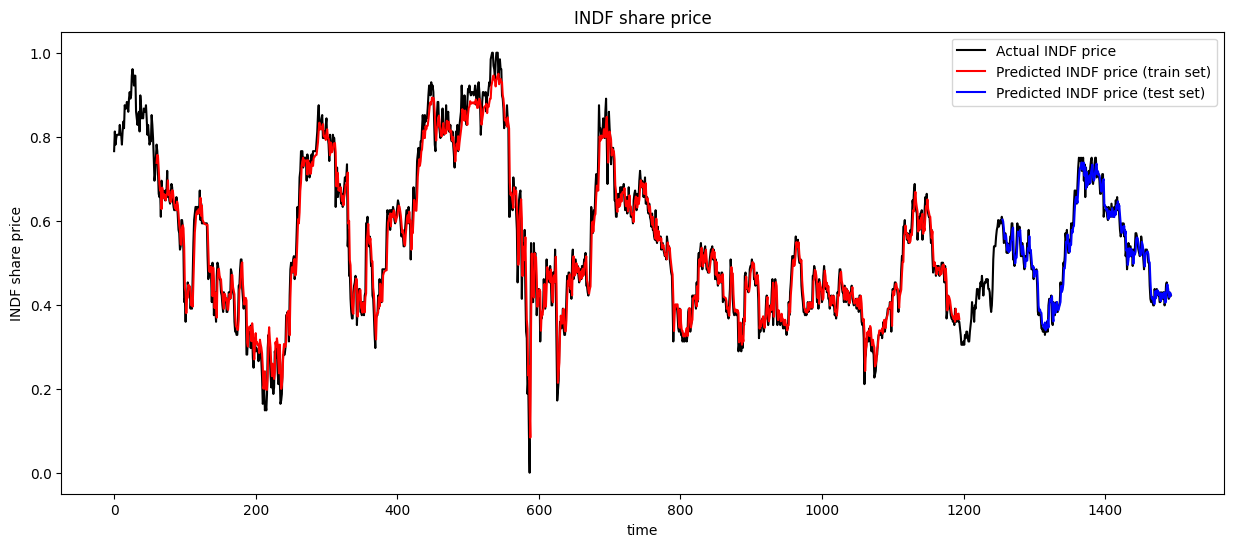

In [50]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [51]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 33ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6404.0849609375
Day 2: Predicted Price = 6406.01953125
Day 3: Predicted Price = 6407.5205078125
Day 4: Predicted Price = 6408.9423828125
Day 5: Predicted Price = 6410.1796875
Day 6: Predicted Price = 6411.2548828125
Day 7: Predicted Price = 6412.1865234375
Day 8: Predicted Price = 6413.001953125
Day 9: Predicted Price = 6413.734375
Day 10: Predicted Price = 6414.41357421875
Day 11: Predicted Price = 6415.0595703125
Day 12: Predicted Price = 6415.6884765625
Day 13: Predicted Price = 6416.3046875
Day 14: Predicted Price = 6416.9111328125
Day 15: Predicted Price = 6417.5048828125
Day 16: Predicted Price = 6418.0830078125
Day 17: Predicted Price = 6418.642578125
Day 18: Predicted Price = 6419.18115234375
Day 19: Predicted Price = 6419.69775390625
Day 20: Predicted Price = 6420.1904296875
Day 21: Predicted Price = 6420.6611328125
Day 22: Predicted Price = 6421.10986328125
Day 23: P

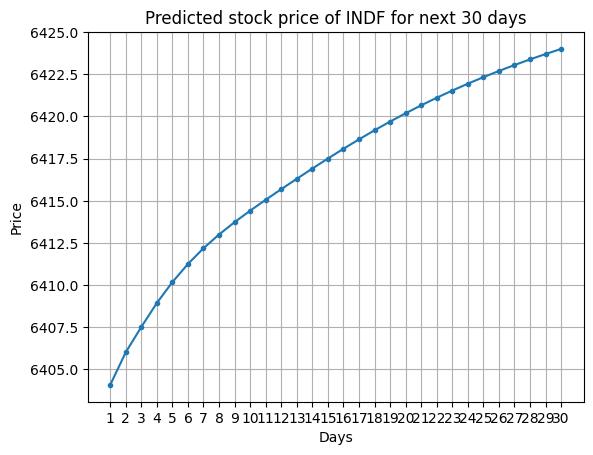

In [52]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [53]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 20ms/step - loss: 6.6567e-04
Validation Loss: 0.0006656698533333838
Validation MSE Loss: 0.0006656698533333838


In [54]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04077536435218911
Testing RMSE: 0.025800579000700624


batchsize = 128

In [55]:
checkpoints = ModelCheckpoint(filepath= 'indf.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=150,
          batch_size=128,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/150
9/9 [==============================] - 2s 271ms/step - loss: 0.0030 - val_loss: 6.9986e-04
Epoch 2/150
9/9 [==============================] - 5s 547ms/step - loss: 0.0030 - val_loss: 6.6872e-04
Epoch 3/150
9/9 [==============================] - 9s 1s/step - loss: 0.0030 - val_loss: 6.6874e-04
Epoch 4/150
9/9 [==============================] - 3s 384ms/step - loss: 0.0029 - val_loss: 6.6880e-04
Epoch 5/150
9/9 [==============================] - 3s 382ms/step - loss: 0.0031 - val_loss: 6.7446e-04
Epoch 6/150
9/9 [==============================] - 3s 402ms/step - loss: 0.0034 - val_loss: 6.9584e-04
Epoch 7/150
9/9 [==============================] - 3s 396ms/step - loss: 0.0031 - val_loss: 7.2930e-04
Epoch 8/150
9/9 [==============================] - 4s 382ms/step - loss: 0.0028 - val_loss: 6.7446e-04
Epoch 9/150
9/9 [==============================] - 3s 355ms/step - loss: 0.0029 - val_loss: 6.7957e-04
Epoch 10/150
9/9 [==============================] - 3s 362ms/step - loss: 0.

In [56]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 49ms/step


In [57]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [58]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04029980491951823
0.025797401911304186


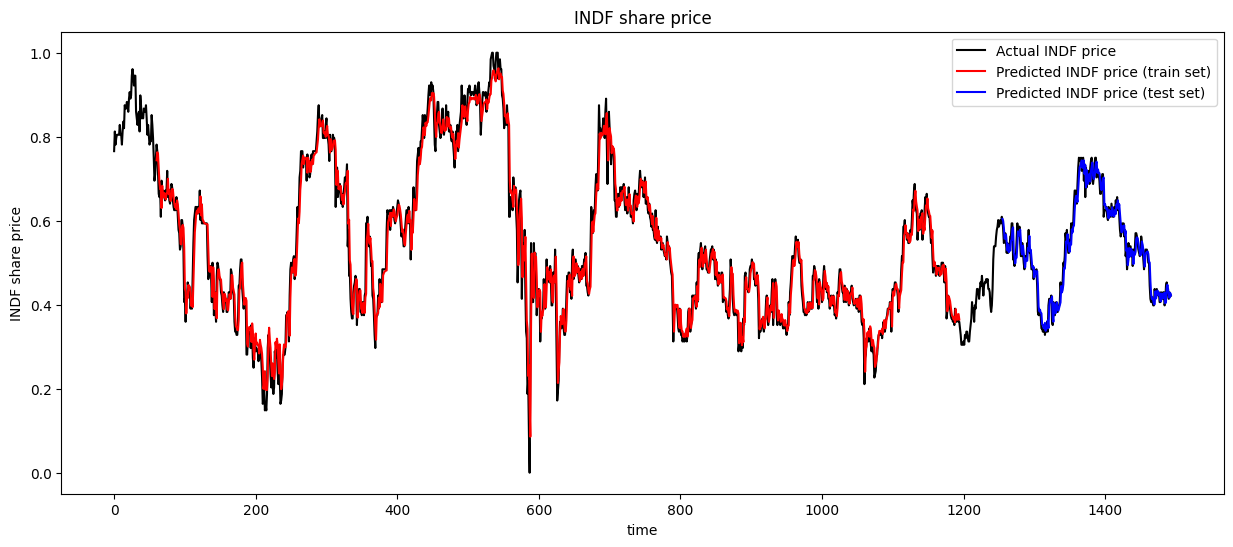

In [59]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual INDF price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted INDF price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted INDF price (test set)")

plt.title(f"INDF share price")
plt.xlabel("time")
plt.ylabel(f"INDF share price")
plt.legend()
plt.show()

In [60]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 110ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 6401.13818359375
Day 2: Predicted Price = 6401.0087890625
Day 3: Predicted Price = 6400.4384765625
Day 4: Predicted Price = 6399.896484375
Day 5: Predicted Price = 6399.26904296875
Day 6: Predicted Price = 6398.58251953125
Day 7: Predicted Price = 6397.85595703125
Day 8: Predicted Price = 6397.10791015625
Day 9: Predicted Price = 6396.35791015625
Day 10: Predicted Price = 6395.62353515625
Day 11: Predicted Price = 6394.91796875
Day 12: Predicted Price = 6394.24951171875
Day 13: Predicted Price = 6393.6220703125
Day 14: Predicted Price = 6393.03466796875
Day 15: Predicted Price = 6392.4853515625
Day 16: Predicted Price = 6391.970703125
Day 17: Predicted Price = 6391.4873046875
Day 18: Predicted Price = 6391.03173828125
Day 19: Predicted Price = 6390.6015625
Day 20: Predicted Price = 6390.19482421875
Day 21: Predicted Price = 6389.80859375
Day 22: Predicted Price = 6389.4433593

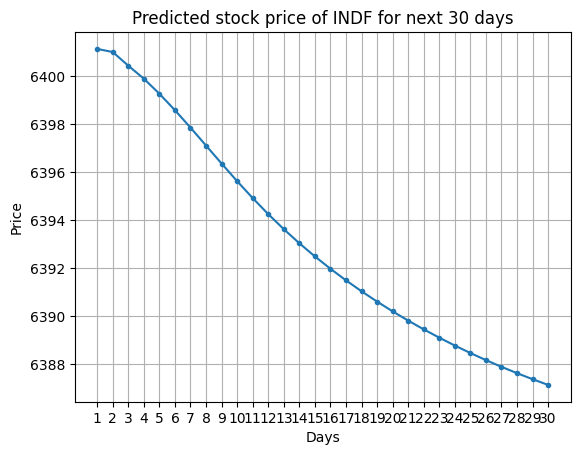

In [61]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of INDF for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [62]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 40ms/step - loss: 6.6551e-04
Validation Loss: 0.0006655059987679124
Validation MSE Loss: 0.0006655059987679124


In [63]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04029980491951823
Testing RMSE: 0.025797401911304186
